# Interactive Proteus parallel example

First go to your notebook Home page, select the mpi cluster, and start some tasks. It should look like this: ![cluster](cluster.png)



## Load IPython support for working with MPI tasks

In [1]:
import ipyparallel
import os
rc = ipyparallel.Client(profile="mpi")
view = rc[:]
view.apply(os.chdir, os.getcwd())

<AsyncResult: chdir>

## Load interactive Proteus module, physics, and numerics on the MPI tasks and solve problem

In [2]:
%%px --block
from proteus.iproteus import * 
from proteus import default_n as n
from proteus import default_p as p
from proteus import default_s,default_so
from proteus.TransportCoefficients import *

class LAD(TC_base):
    """
    The coefficients of the linear advection-diffusion equation
    """
    def __init__(self,M,A,B):
        self.nd=2
        TC_base.__init__(self, 
                         nc=1, #number of components
                         variableNames=['u'],
                         mass      = {0:{0:'linear'}},
                         advection = {0:{0:'linear'}},
                         diffusion = {0:{0:{0:'constant'}}},
                         potential = {0:{0:'u'}},
                         reaction  = {0:{0:'linear'}})
        self.M=M;
        self.A=A;
        self.B=B;
    
    def evaluate(self,t,c):
        c[('m',0)][:]         = self.M*c[('u',0)]  
        c[('dm',0,0)][:]      = self.M
        c[('f',0)][...,0]     = self.B[0]*c[('u',0)]
        c[('f',0)][...,1]     = self.B[1]*c[('u',0)]
        c[('df',0,0)][...,0]  = self.B[0]
        c[('df',0,0)][...,1]  = self.B[1]
        c[('a',0,0)][...,0,0] = self.A[0][0]
        c[('a',0,0)][...,1,1] = self.A[1][1]

#physics
p.name = "ladr_2d"
p.nd = 2; #Two dimensions
p.L=(1.0,1.0,1.0); 
p.T=1.0

p.coefficients=LAD(M=1.0,
                 A=[[0.001,0.0],
                    [0.0,0.001]],
                 B=[2.0,1.0])

def getDBC(x,flag):
    if x[0] == 0.0 or x[1] == 0.0:
        return lambda x,t: 1.0
    elif x[0] == p.L[0] or x[1] == p.L[1]:
        return lambda x,t: 0.0
    else:
        return None

p.dirichletConditions = {0:getDBC}
p.advectiveFluxBoundaryConditions = {}
p.diffusiveFluxBoundaryConditions = {0:{}}
p.periodicDirichletConditions = None
class IC:
    def __init__(self):
        pass
    def uOfXT(self,x,t):
        if x[0] <= 0.0 or x[1] <= 0.0:
            return 1.0
        else:
            return 0.0

p.initialConditions  = {0:IC()}
#numerics
n.timeIntegration = n.BackwardEuler_cfl
n.stepController = n.Min_dt_cfl_controller
n.runCFL=1.0
n.femSpaces = {0:n.C0_AffineLinearOnSimplexWithNodalBasis}
n.elementQuadrature = n.SimplexGaussQuadrature(p.nd,3)
n.elementBoundaryQuadrature = n.SimplexGaussQuadrature(p.nd-1,3)
n.subgridError = n.AdvectionDiffusionReaction_ASGS(p.coefficients,p.nd,lag=False)
n.shockCapturing = n.ResGradQuad_SC(p.coefficients,p.nd,
                               shockCapturingFactor=0.99,
                               lag=True)
n.numericalFluxType = n.Advection_DiagonalUpwind_Diffusion_SIPG_exterior
n.nnx=41; n.nny=41
n.tnList=[float(i)/40.0 for i in range(11)]
n.matrix = n.SparseMatrix
n.multilevelLinearSolver = n.KSP_petsc4py
n.linearSmoother = None#n.Jacobi
n.l_atol_res = 1.0e-8
n.parallelPartitioningType = n.MeshParallelPartitioningTypes.node
n.nLayersOfOverlapForParallel = 0
n.periodicDirichletConditions = None

from proteus import Comm
comm = Comm.get()
pList = [p]
nList = [n]
so = default_so
so.name = pList[0].name = "ladr_2d"
so.sList=[default_s]
so.tnList = n.tnList
nList[0].multilevelLinearSolver=default_n.KSP_petsc4py
ns = NumericalSolution.NS_base(so,pList,nList,so.sList,opts)
ns.calculateSolution('run1')
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
n = len(x)

## Combine subdomain solutions and plot

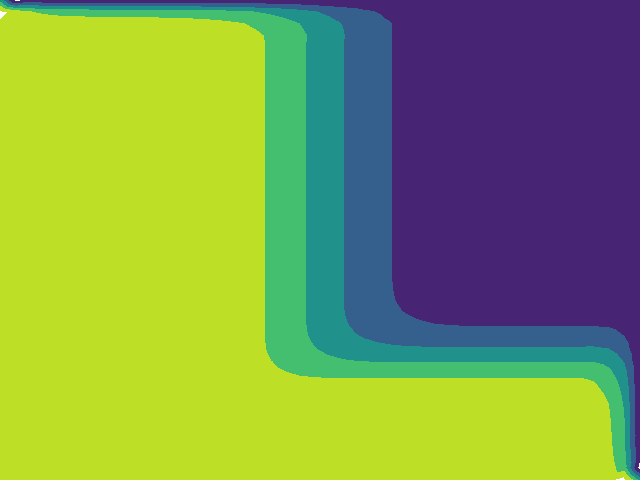

In [3]:
from parplot import parallel_plot
import numpy as np
r = ipyparallel.Reference
png = parallel_plot(view, 'tricontourf',
                    r('x'),
                    r('y'),
                    r('triangles'),
                    r('u'),
                    levels=np.linspace(0,1.01,6),
                    xlim=(0,1),
                    ylim=(0,1),
                   )